In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib widget


def draw(ax, verts, faces=[], color=[]):
    """
    Draw the object defined by vertices and faces.
    """

    if verts.ndim == 1:
        if color:
            ax.scatter3D(verts[0], verts[1], verts[2], c=color)
        else:
            ax.scatter3D(verts[0], verts[1], verts[2], c=color)
    else:
        if color:
            ax.scatter3D(verts[:, 0], verts[:, 1], verts[:, 2], c=color)
        else:
            ax.scatter3D(verts[:, 0], verts[:, 1], verts[:, 2])

    if faces:
        ax.add_collection3d(Poly3DCollection(faces,
                                             facecolors='blue',
                                             linewidths=1,
                                             edgecolor='b',
                                             alpha=0.25))

def build_projection_matrix(focal_length=1.0, reverse=False):
    """
    Builds a simple projection matrix given the distance of the viewing plane
    from the camera.
    
    Args:
        focal_length -- distance from lens to sensor (default 1.0)
        reverse -- determines projection to virtual plane (False) or sensor plane (True)
    """
    
    proj = np.array([[focal_length, 0, 0, 0],
                     [0, focal_length, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 1, 0]])
    
    if reverse is True:
        proj[2:, 2] *= -1
        
    return proj


def draw_camera(ax, camera_pos, V, d=1.0, draw_physical=False):
    """Draws a camera at `camera_pos` with a view plane defined by transform `T` and distance `d`.
    
    Args:
        ax -- matplotlib axis
        camera_pos -- camera's position in world space
        V -- camera transformation matrix (virtual)
        d -- distance of viewing plane from camera (default 1.0)
        draw_physical -- draw physical sensor plane (default False)
    """
    # Viewing Plane
    view_plane = np.array([[-1, -1, 0],
                           [1, -1, 0],
                           [1, 1, 0],
                           [-1, 1, 0]])

    view_plane_virtual = transform_points(view_plane, np.linalg.inv(V))
    
    forward_vector = V[2, :-1]
    
    M = np.eye(4)
    f_vec = forward_vector / np.linalg.norm(forward_vector)
    M[:-1, -1] = f_vec.T * d
    view_plane_virtual = transform_points(view_plane_virtual, M)
    view_faces = [[view_plane_virtual[0], view_plane_virtual[1], view_plane_virtual[2], view_plane_virtual[3]]]
    
    draw(ax, camera_pos)
    draw(ax, view_plane_virtual, view_faces)
    for i in range(len(view_plane)):
        ax.plot([camera_pos[0], view_plane_virtual[i, 0]],
                [camera_pos[1], view_plane_virtual[i, 1]],
                [camera_pos[2], view_plane_virtual[i, 2]], c='k')
        
    if draw_physical:
        view_plane_physical = transform_points(view_plane, np.linalg.inv(V))

        forward_vector = -V[2, :-1]
        M = np.eye(4)
        f_vec = forward_vector / np.linalg.norm(forward_vector)
        M[:-1, -1] = f_vec.T * d
        view_plane_physical = transform_points(view_plane_physical, M)
        view_faces = [[view_plane_physical[0], view_plane_physical[1], view_plane_physical[2], view_plane_physical[3]]]

        draw(ax, view_plane_physical, view_faces)
        for i in range(len(view_plane)):
            ax.plot([camera_pos[0], view_plane_physical[i, 0]],
                    [camera_pos[1], view_plane_physical[i, 1]],
                    [camera_pos[2], view_plane_physical[i, 2]], c='k')
            
            
def compute_projected_points3d(points, camera_matrix, projection_matrix, focal_length, reverse=False):
    """Computes 3D points on the image plane as seen from world space.
    
    Args:
        points -- 3D world points to be drawn
        camera_matrix -- world-to-camera matrix
        projection_matrix -- camera's projection matrix
        focal_length -- focal length of camera
        reverse -- project to virtual (False) or physical (True)
    """
    
    forward_vector = camera_matrix[2, :-1]
            
    M = np.eye(4)
    f_vec = forward_vector / np.linalg.norm(forward_vector)
    M[:-1, -1] = f_vec.T * (focal_length - 1)
    
    if reverse:
        M[:-1, -1] = -2 * f_vec.T - M[:-1, -1]        
        
    return transform_points(points, M @ np.linalg.inv(camera_matrix) @ projection_matrix @ camera_matrix)
    

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm


def look_at(src, to, up):
    """Creates a camera matrix located at `src` looking towards `to`."""
    forward = normalize(src - to)
    right = np.cross(normalize(up), forward)
    up = np.cross(forward, right)

    forward = -forward

    camera_matrix = np.array([
        [right[0], right[1], right[2], -np.dot(right, src)],
        [up[0], up[1], up[2], -np.dot(up, src)],
        [forward[0], forward[1], forward[2], -np.dot(forward, src)],
        [0, 0, 0, 1]
    ])

    return camera_matrix


def transform_point(point, T):
    proj_point = T @ np.append(point, 1)
    proj_point /= proj_point[3]

    return proj_point[:3]


def transform_points(points, T):
    homogeneous_points = np.hstack((points, np.ones((len(points), 1))))
    proj_points = T @ homogeneous_points.T
    proj_points /= proj_points[3, :]

    return proj_points[:3, :].T

In [2]:


camera = np.array([0.0, 1.0, 0.0])
at = np.array([0.0, 0.0, 0.0])
up = np.array([1.0, 0.0, 0.0])

M = look_at(camera, at, up)
print(M)

[[ 0.  0.  1. -0.]
 [ 1.  0.  0. -0.]
 [-0. -1. -0.  1.]
 [ 0.  0.  0.  1.]]


NameError: name 'proj_points_virtual' is not defined

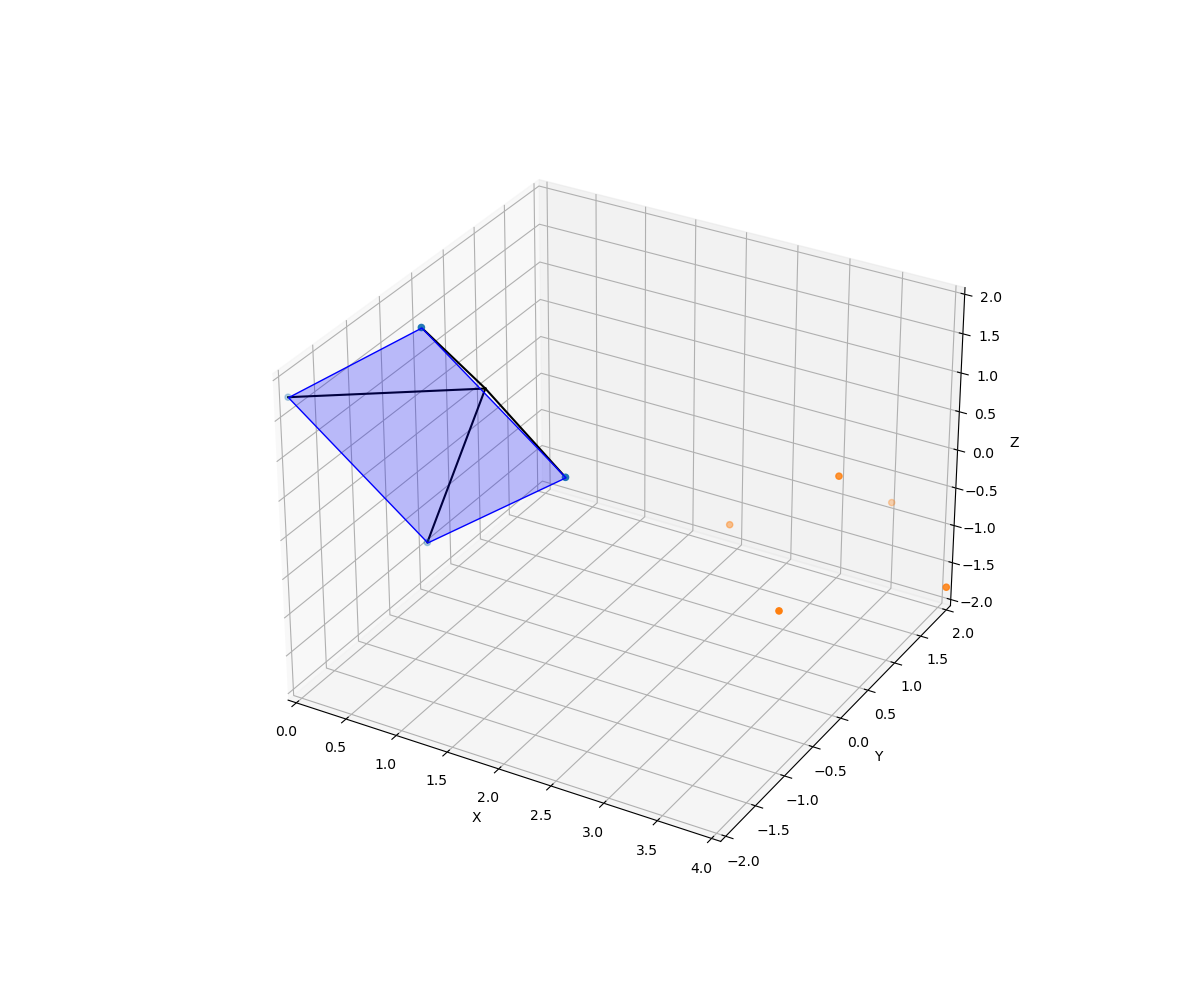

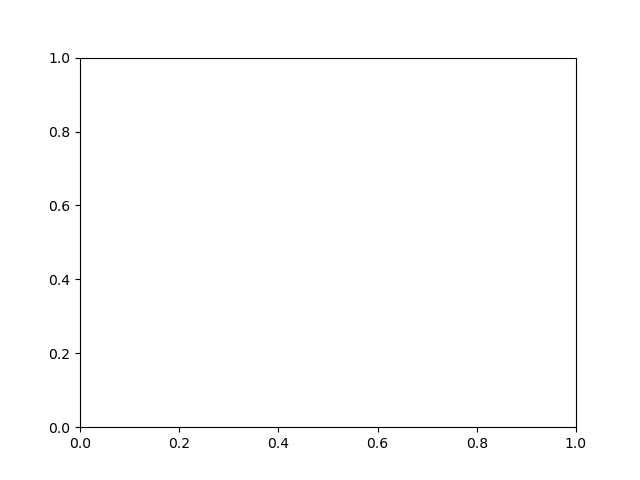

In [3]:
# Camera location
camera = np.array([0.0, 1.0, 0.0])
at = np.array([0.0, 0.0, 0.0])
up = np.array([1.0, 0.0, 1.0])
f = 1

# Build camera matrix
camera_matrix = look_at(camera, at, up)

# Get the projection matrix and calculate the projected point.
proj_matrix = build_projection_matrix(f)

# Points in 3D space
points = np.array([[4, 0., 1],
                   [3, 0, 0],
                   [4, -1, 0],
                   [5, 0, 0],
                   [4, 1, 0]])

fig1 = plt.figure(figsize=(12,10))
fig2 = plt.figure()
ax3d = fig1.add_subplot(111, projection='3d')
ax2d = fig2.add_subplot(111)
ax3d.set_xlim([0, 4])
ax3d.set_ylim([-2, 2])
ax3d.set_zlim([-2, 2])
ax3d.set_xlabel("X")
ax3d.set_ylabel("Y")
ax3d.set_zlabel("Z")

# Compute projected points on virtual plane
# proj_points_virtual = compute_projected_points3d(points, camera_matrix, proj_matrix, f)

# Compute projected points on sensor plane
# proj_points_physical = compute_projected_points3d(points, camera_matrix, build_projection_matrix(f, True), f, True)

# Transform to camera space
T = proj_matrix @ camera_matrix
# camera_points = transform_points(points, camera_matrix)
# image_points = transform_points(points, T)

# Draw camera
draw_camera(ax3d, camera, camera_matrix, f, False)
draw(ax3d, points)
draw(ax3d, proj_points_virtual)
# draw(ax3d, proj_points_physical)

# Draw line from projected points to the 3D point
# for i in range(points.shape[0]):
#     ax3d.plot([proj_points_physical[i, 0], points[i, 0]],
#               [proj_points_physical[i, 1], points[i, 1]],
#               [proj_points_physical[i, 2], points[i, 2]], c='r')
for i in range(points.shape[0]):
    ax3d.plot([camera[0], points[i, 0]],
              [camera[1], points[i, 1]],
              [camera[2], points[i, 2]], c='r')
    
ax3d.set_axis_off()

ax2d.scatter(image_points[:, 0], image_points[:, 1], c=camera_points[:, 2])
ax2d.set_xlim([-1, 1])
ax2d.set_ylim([-1, 1])

plt.show()